# Assignment 7: Linear Model Selection and Regularization

Dataset(s) needed:
Kaggle House Prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## Learning Objectives
- Produce a model with l2 regularization, with a statistically significant improvement over a model without regularization.
- Produce a model with l1 regularization, with a statistically significant improvement over a model without regularization.
- Produce a model with both l1 and l2 regularization terms, with a statistically significant improvement over a model without regularization.
- Produce a logistic regression model with a statistically significant improvement over the null model (a model without input - variables).
- Produce a generalized additive model with a statistically significant improvement over the null model (a model without input variables).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('House Prices.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


 Question 1.1: Drop the Id column as it is not needed for prediction

In [3]:
df = df.drop('Id', axis=1)

 Question 1.2: Visualize a scatter plot of 'GrLivArea' in the x-axis and 'SalePrice' in the y-axis. Can you spot any outliers?

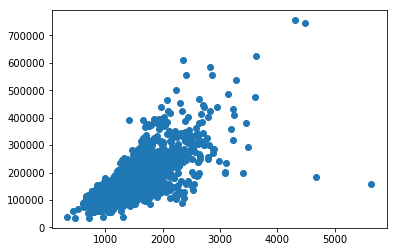

In [4]:
import matplotlib.pyplot as plt

plt.scatter(df.GrLivArea, df.SalePrice)


There do seem to be some outlying values, with GrLivArea > 4000 and maybe also those with Sale price > 600k (though those are less extreme).

 Question 1.3: Removing outliers in the data for all GrLivArea greater than 4000 then check the scatter plot again

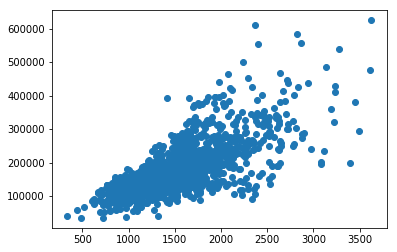

In [5]:
# Remove outliers for data['GrLivArea']>4000
df = df[df.GrLivArea <= 4000]
plt.scatter(df.GrLivArea, df.SalePrice)
#To Do Create a scatter plot

Quesiont 2.1: Convert categorical variable into dummy variables using pandas get_dummies API


In [17]:
df = pd.get_dummies(df)

Question 2.2: Impute missing data by the median of each column.

In [19]:
df = df.fillna(df.median())

Question 2.2b: Make sure that there are no null values remaining

In [22]:
df.isna().sum().sum()

0

Question 2.3: Generate train test split 70/30. Set random_state=42

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    
    df.drop('SalePrice', axis=1),
    df['SalePrice'],
    test_size=0.3,
    random_state=42

)


Question 3.1: Train a linear regression algorithm to predict `SalePrice` from the remaining features.

In [39]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, ElasticNetCV
from sklearn.metrics import mean_squared_error

#Fit a linear regression model to this data
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Question 3.2: Evaluate the model and report the performance on both training and test data. These numbers will serve as our benchmark performance.

In [49]:
# train MSE
mean_squared_error(y_train, model.predict(X_train))

328972320.18979836

In [50]:
#test MSE 
mean_squared_error(y_test, y_pred)

559710152.4717978

We now train a regularized version of `LinearRegression` called `Lasso` (you can load it from the same library). `Lasso` has an argument called `alpha`, which is the **shrinkage parameter** we referred to earlier.

Question 4.1: Let `alpha = 0.000001` and train a `Lasso` algorithm. Show that the resulting model is practically identical to the one we trained with `LinearRegression`. There are different ways to show this, so you will need to think of a way. <span style="color:red" float:right>[2 point]</span>

In [52]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 0.000001, max_iter=2000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

# we can show they are similar by looking at the sum of the absolute differences of the 
# coefficients in the two models
print(sum([abs(a-b) for a, b in zip(model.coef_, lasso.coef_)]))

# also, we can compare their test MSE
print(abs(mean_squared_error(y_test, y_pred) - mean_squared_error(y_test, lasso_pred)))

1367992.9117032492
8628897.319212794


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167611117167.74036, tolerance: 634515517.391386
  positive)


In [51]:
#Compute the RMSE 
mean_squared_error(y_test, lasso_pred)

568339049.7910106

Question 4.2: Iteratively train a new `Lasso` model, letting `alpha` change each time to one of the values given by `alpha_vals` below, keeping track of the performance on the training and test data each time, and storing the model's coefficients each time (the `coef_` attribute of the trained model)

In [57]:
# i'm going to silence warnings, because they are getting annoying
import sys
import warnings
import os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [ ]:
alpha_vals = np.arange(0.01, 5, .01) # values of alpha we want to iterate over

coef_results = {}
train_MSE = []
test_MSE = []
for alpha in alpha_vals:
    alpha_model = Lasso(alpha=alpha)
    alpha_model.fit(X_train, y_train)
    coef_results[alpha] = alpha_model.coef_
    train_MSE.append(mean_squared_error(y_train, alpha_model.predict(X_train)))
    test_MSE.append(mean_squared_error(y_test, alpha_model.predict(X_test)))
    if alpha % .25 == 0:
        print(f'Finished alpha: {alpha}')
    
    
    
# pd.DataFrame({'linreg': linreg.coef_, 'lasso': clf.coef_}).head(10)



Question 4.3: Using a visual, show how the performance on the training and test data changed as we gradually increased `alpha`.

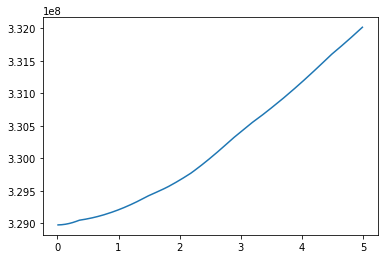

In [62]:
plt.plot(alpha_vals, train_MSE)

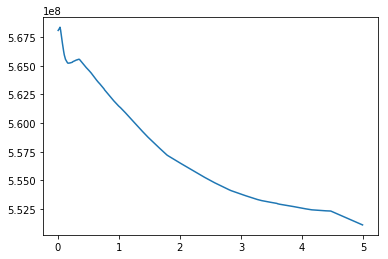

In [61]:
plt.plot(alpha_vals, test_MSE)

Question 4.4: Using a visual, show how the model's coefficients changed as we gradually increased the shrinkage parameter `alpha`. HINT: They should appear to be shrinking toward zero as you increase `alpha`!

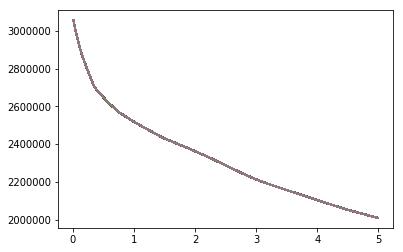

In [69]:
# I tried plotting each coefficient separately but it was totally unintelligible.
# Instead, I'll just plot the sum of the absolute value of all the coefficients, for each alpha, since that sum
# should also be monotonically decreasing
for coef_i in range(len(df.columns)):
    plt.plot(alpha_vals, [sum(abs(coef_results[a])) for a in alpha_vals])
    

Question 5.1: Repeat steps in Question 4 this time using `Ridge` instead of `Lasso`. We will use the following range for `alpha`: <span style="color:red" float:right>[2 point]

In [71]:
from sklearn.linear_model import Ridge
alpha_vals = np.arange(0.1, 200, 1)

coef_results = {}
train_MSE = []
test_MSE = []
for alpha in alpha_vals:
    alpha_model = Ridge(alpha=alpha)
    alpha_model.fit(X_train, y_train)
    coef_results[alpha] = alpha_model.coef_
    train_MSE.append(mean_squared_error(y_train, alpha_model.predict(X_train)))
    test_MSE.append(mean_squared_error(y_test, alpha_model.predict(X_test)))
    

Question 5.2: Using a visual, show how the performance on the training and test data changed as we gradually increased `alpha`.

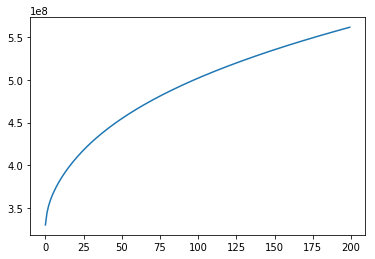

In [72]:
plt.plot(alpha_vals, train_MSE)

Question 5.3: Using a visual, show how the model's coefficients changed as we gradually increased the shrinkage parameter `alpha`.

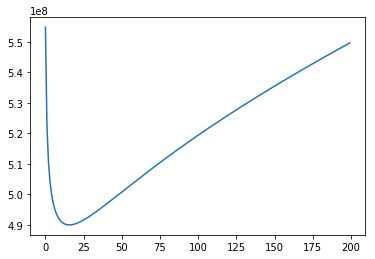

In [73]:
plt.plot(alpha_vals, test_MSE)

Question 6: Repeat questions 5.1 - 5.3 using elasticnet experimenting with differnet values of alpha

In [81]:
from sklearn.linear_model import ElasticNet

alpha_vals = np.arange(0.01, 1, .01) # values of alpha we want to iterate over

coef_results = {}
train_MSE = []
test_MSE = []
for alpha in alpha_vals:
    alpha_model = ElasticNet(alpha=alpha)
    alpha_model.fit(X_train, y_train)
    coef_results[alpha] = alpha_model.coef_
    train_MSE.append(mean_squared_error(y_train, alpha_model.predict(X_train)))
    test_MSE.append(mean_squared_error(y_test, alpha_model.predict(X_test)))
    if alpha % .1 == 0:
        print(f'Finished alpha: {alpha}')

Finished alpha: 0.2
Finished alpha: 0.4
Finished alpha: 0.8


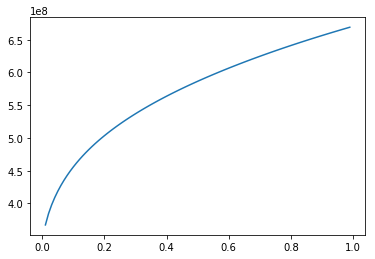

In [82]:
plt.plot(alpha_vals, train_MSE)

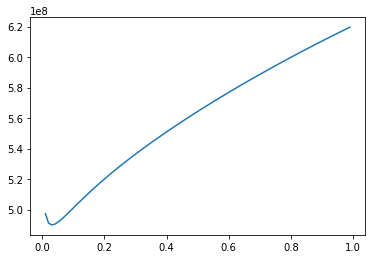

In [83]:
plt.plot(alpha_vals, test_MSE)

Question 7: Based on the results, briefly describe the effect of changing `alpha` on the coefficients of both `Ridge`, `Lasso`, anf `ElasticNet`. What value of `alpha` would you choose for each case? You do not need to give a precise answer, but choose a number.

For Ridge, test MSE starts to increase after about alpha = 20, so that is a good break point.

For Lasso, test MSE starts to plateau at about alpha = 4.5, so I would pick a value between 4 and 5.

Elastic net is trickiest. It looks like test MSE starts to increase at a very low value -- less than 0.1. So I would pick a small value, maybe 0.05. 

Question 8: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include:

What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work

Going into this assignment, I had exactly 0 experience using regularization with linear regression models, except for maybe a brief mention of it in a statistics course. So it was very informative to try it out on some real data.

The trickiest part to me was selecting a value for alpha. In the case of Ridge regression, the test MSE followed an error curve that made selecting a value pretty straightforward. But it was less obvious where to put the break point in the other two cases. I suspect that picking a value of alpha is as much art as science and is something that simply requires hands-on experience.